In [1]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

True


# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [3]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '37242ba43',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/IPython',
 'ipython_version': '8.12.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.0-1064-azure-x86_64-with-glibc2.10',
 'sys_executable': '/anaconda/envs/azureml_py38_PT_and_TF/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'}


In [ ]:
# %pip install -r "C:\Users\jesus\Desktop\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt" 

# %pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt'

In [8]:
# %pip install tensorflow[and-cuda]

In [2]:
# %pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==1.12.1+cu113
Note: you may need to restart the kernel to use updated packages.


In [114]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

ModuleNotFoundError: No module named 'torch'

In [6]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13113209531682466281
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14821294080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8240896653758239225
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [7]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [5]:
# %pip install Pillow --upgrade

In [70]:
DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_artists\train_10_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"


TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

In [9]:
# globals

DATA_DIR = '/home/xnmaster/Pictures'
TRAIN_1_DIR = '/home/xnmaster/Pictures/train_10_artists/train_10_artists'

TRAIN_DIRS = [TRAIN_1_DIR]

# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
TEST_DIR = "/home/xnmaster/Pictures/test"

Execute in local and virtual
(no cal cada vegada, només una vegada pq elimina les fotos que no són vàlides)

In [ ]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


In [10]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 2600
Number of files in the folder TEST_DIR: 10116


After augmentation

In [12]:
df = pd.read_csv('/home/xnmaster/Pictures/all_data_info.csv') # r'\train_info\train_info.csv'
print("df.shape", df.shape)

df.shape (103250, 12)


In [13]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [14]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

                             artist    date              genre  pixelsx   
185                  Giorgio Vasari    1534           portrait   3512.0  \
731                       Juan Gris    1918          cityscape   2844.0   
994                       Juan Gris    1917         still life   3918.0   
1084   John Roddam Spencer Stanhope    1860     genre painting   4249.0   
1105                 Henri Rousseau    1908          cityscape   3403.0   
9984   John Roddam Spencer Stanhope     NaN  symbolic painting   1309.0   
19876              Georgia O'Keeffe  1915.0           abstract   1400.0   
28748                    Franz Marc    1913    animal painting    951.0   
46256           Esaias van de Velde    1622          landscape    942.0   
98236                 George Inness     NaN  literary painting    376.0   

       pixelsy  size_bytes     source                         style   
185     4850.0  10360549.0    wikiart  Mannerism (Late Renaissance)  \
731     3882.0   5393504.0    wi

Keep the works of artists who have a representation above 50%

In [15]:
# Step 1: Count occurrences of each artist
artist_counts = df['artist'].value_counts()

Artists

In [76]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = train_df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

artists = {} # holds artist hash & the count
for a in train_df['artist']:
    if (a not in artists):
        artists[a] = 1
    else:
        artists[a] += 1

training_set_artists = []
for a,count in artists.items():
    if(int(count) >= 300):
        training_set_artists.append(a)

print("number of artsits",len(training_set_artists))

print("\nlist of artists...\n", training_set_artists)

test_df.shape (23814, 2)
train_df.shape (79426, 2)
number of artsits 38

list of artists...
 ['Ivan Aivazovsky', 'Gustave Dore', 'Odilon Redon', 'Rembrandt', 'Edgar Degas', 'Claude Monet', 'Albrecht Durer', 'Francisco Goya', 'Theophile Steinlen', 'Ivan Shishkin', 'Giovanni Battista Piranesi', 'Camille Corot', 'Pierre-Auguste Renoir', 'Childe Hassam', 'Raphael Kirchner', 'James Tissot', 'Alfred Sisley', 'Paul Cezanne', 'John Singer Sargent', 'Vincent van Gogh', 'Zdislav Beksinski', 'Camille Pissarro', 'Eugene Boudin', 'Fernand Leger', 'Boris Kustodiev', 'Nicholas Roerich', 'Ilya Repin', 'Martiros Saryan', 'Isaac Levitan', 'Pyotr Konchalovsky', 'Salvador Dali', 'Pablo Picasso', 'Henri Matisse', 'Marc Chagall', 'Erte', 'Paul Gauguin', 'Eyvind Earle', 'Zinaida Serebriakova']


In [16]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

# artists = {} # holds artist hash & the count
# for a in filtered_df['artist']:
#     if (a not in artists):
#         artists[a] = 1
#     else:
#         artists[a] += 1

# training_set_artists = []
# for a,count in artists.items():
#     if(int(count) >= 200): # it takes no more than 200 artists
#         training_set_artists.append(a)

# print("number of artists",len(training_set_artists))

# print("\nlist of artists...\n", training_set_artists)


test_df.shape (23814, 2)
train_df.shape (103240, 2)


In [17]:
artists = {'Ivan Aivazovsky': 500,
 'John Singer Sargent': 500,
 'Pierre-Auguste Renoir': 500,
 'Marc Chagall': 500,
 'Pablo Picasso': 500,
 'Zdislav Beksinski': 500,
 'Ivan Shishkin': 500,
 'Gustave Dore': 500,
 'Ilya Repin': 500,
 'Giovanni Battista Piranesi': 500}

In [18]:
training_set_artists = ['Ivan Aivazovsky',
 'John Singer Sargent',
 'Pierre-Auguste Renoir',
 'Marc Chagall',
 'Pablo Picasso',
 'Zdislav Beksinski',
 'Ivan Shishkin',
 'Gustave Dore',
 'Ilya Repin',
 'Giovanni Battista Piranesi']

In [19]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
82,Ivan Aivazovsky,81750.jpg


In [20]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
591,Giovanni Battista Piranesi,96147.jpg
634,Giovanni Battista Piranesi,94943.jpg
681,Giovanni Battista Piranesi,97939.jpg
748,Giovanni Battista Piranesi,98150.jpg


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

## wandb
Execute following lines if we use wandb

In [21]:
# %pip install wandb -qU

In [58]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()
# 0927244f833ccea1b247099feaaaf54084a5c30c

KeyboardInterrupt: 

## without wandb

In [22]:
len(training_set_artists)

10

In [ ]:
# augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]


# def data_augmentation(x):
#     for layer in augmentation_layers:
#         x = layer(x)
#     return x


# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [23]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [24]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

In [25]:
model_RMS = Sequential()
model_RMS.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_RMS.add(Dense(
  num_classes,
  activation='softmax'
))

model_RMS.layers[0].trainable = False

# Compile Model

## Adam

In [26]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [27]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

## RMSprop

In [28]:
model_RMS.compile(optimizer ='RMSprop', 
              loss ='categorical_crossentropy', 
              metrics =['accuracy'])

# Setup the image data generator for each training directory 

In [29]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)

Number of files in the folder TRAIN_1_DIR: 2600
Number of files in the folder TEST_DIR: 10116


In [30]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 52
TEST_BATCH_SIZE: 36


In [31]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split
    )

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    
    print("\ntraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen

print("defined setup_generators_with_augmentation()")


defined setup_generators_with_augmentation()


In [33]:
# delete some unused dataframes to free some RAM for training
del df
del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

16431

In [34]:
all_train_dfs[0]

,artist,new_filename
602,Giovanni Battista Piranesi,11889.jpg
668,Giovanni Battista Piranesi,19571.jpg
697,Giovanni Battista Piranesi,14108.jpg
773,Giovanni Battista Piranesi,1155.jpg
784,Giovanni Battista Piranesi,18290.jpg
...,...,...
84070,Zdislav Beksinski,15108.jpg
84115,Zdislav Beksinski,101998.jpg
85235,Zdislav Beksinski,18742.jpg
85237,Zdislav Beksinski,10293.jpg


In [35]:
len(all_train_dfs)

9

In [36]:
all_train_dfs[0]

,artist,new_filename
602,Giovanni Battista Piranesi,11889.jpg
668,Giovanni Battista Piranesi,19571.jpg
697,Giovanni Battista Piranesi,14108.jpg
773,Giovanni Battista Piranesi,1155.jpg
784,Giovanni Battista Piranesi,18290.jpg
...,...,...
84070,Zdislav Beksinski,15108.jpg
84115,Zdislav Beksinski,101998.jpg
85235,Zdislav Beksinski,18742.jpg
85237,Zdislav Beksinski,10293.jpg


In [42]:
train_gens = [None] * 6
valid_gens = [None] * 6
test_gen  = None  # only 1 test_gen

for i in range(6):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=all_train_dfs[i], train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED,
        list_of_classes=training_set_artists, test_dataframe=test_df,
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )

--------------------
706 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 394 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 131 validated image filenames belonging to 10 classes.



test set ImageDataGenerator
Found 10113 validated image filenames.
--------------------
554 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 330 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 110 validated image filenames belonging to 10 classes.

test set ImageDataGenerator


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 181 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 181 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 114 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/imag

Found 10113 validated image filenames.
--------------------
538 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 306 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 102 validated image filenames belonging to 10 classes.

test set ImageDataGenerator
Found 10113 validated image filenames.
--------------------
526 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 303 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 101 validated image filenames belonging to 10 classes.


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 130 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 130 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/im


test set ImageDataGenerator
Found 10113 validated image filenames.
--------------------
527 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 300 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 100 validated image filenames belonging to 10 classes.

test set ImageDataGenerator
Found 10113 validated image filenames.
--------------------
541 images in /home/xnmaster/Pictures/train_10_artists/train_10_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 318 validated image filenames belonging to 10 classes.

validation set ImageDataGenerator
Found 105 validated image filenames belonging to 10 classes.


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 127 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 127 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/im


test set ImageDataGenerator
Found 10113 validated image filenames.


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13701 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [43]:
MAX_EPOCHS = 5 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [44]:
MAX_EPOCHS

30

In [45]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

In [19]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_13000im_10art"
    # track hyperparameters and run metadata with wandb.config
    # config={
    #     "layer_1": 512,
    #     "activation_1": "softmax", # relu
    #     "dropout": random.uniform(0.01, 0.80),
    #     "layer_2": 10,
    #     # "activation_2": "softmax",
    #     "optimizer": "adam",
    #     "loss": "sparse_categorical_crossentropy",
    #     "metric": "accuracy",
    #     "epoch": 8,
    #     "batch_size": 256,
    # },
)

# [optional] use wandb.config as your config
# config = run.config


In [38]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 46s 3s/step - loss: 2.2741 - accuracy: 0.2589 - val_loss: 4.9939 - val_accuracy: 0.1832
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.1734 - accuracy: 0.6091 - val_loss: 5.7783 - val_accuracy: 0.2824
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.7611 - accuracy: 0.7538 - val_loss: 5.9827 - val_accuracy: 0.3359
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.5465 - accuracy: 0.8503 - val_loss: 6.1913 - val_accuracy: 0.3511
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4157 - accuracy: 0.8883 - val_loss: 6.3172 - val_accuracy: 0.3511
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.3335 - accuracy: 0.9315 - val_loss: 6.3850 - val_accuracy: 0.3511
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.2569 - accuracy: 0.9467 - val_loss: 6.2816 - val_accuracy: 0.3740
Epoch 8/20
8/8 [==================

In [39]:
run.finish()

batch/accuracy,▁▅▆▆█▇▇█████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇█
epoch/val_loss,▁▅▆▇██▇▇▇▇█▇▇▇▇▇▇▇██
batch/accuracy,1.0


In [41]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "sgd_13000im_10art"
)

In [42]:
histories_sgd = model_sgd.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.3816 - accuracy: 0.2386 - val_loss: 3.5298 - val_accuracy: 0.2519
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.3757 - accuracy: 0.5178 - val_loss: 3.7344 - val_accuracy: 0.3282
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 1.0062 - accuracy: 0.6675 - val_loss: 3.9953 - val_accuracy: 0.3206
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.8215 - accuracy: 0.7259 - val_loss: 4.0012 - val_accuracy: 0.3511
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.6924 - accuracy: 0.7944 - val_loss: 4.1198 - val_accuracy: 0.3206
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.5992 - accuracy: 0.8198 - val_loss: 4.1945 - val_accuracy: 0.3282
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.5324 - accuracy: 0.8655 - val_loss: 4.2109 - val_accuracy: 0.3740
Epoch 8/20
8/8 [==================

In [43]:
run.finish()

batch/accuracy,▁▄▆▆▇▇▇▇▇█▇▇▇███████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▇▇▇▇▇▇█████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▄▆▄▅▇██▇▇▇▇▇█▇████
epoch/val_loss,▁▂▄▄▅▅▆▅▆▆▇▇▇▇▇▇████
batch/accuracy,0.98077


In [44]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "rms_13000im_10art"
)

In [45]:
histories_RMS = model_RMS.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.2772 - accuracy: 0.2792 - val_loss: 3.8644 - val_accuracy: 0.2672
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.1213 - accuracy: 0.6091 - val_loss: 3.9901 - val_accuracy: 0.3588
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.8072 - accuracy: 0.7310 - val_loss: 4.1888 - val_accuracy: 0.3740
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.6552 - accuracy: 0.7995 - val_loss: 4.3235 - val_accuracy: 0.3664
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4821 - accuracy: 0.8832 - val_loss: 4.6318 - val_accuracy: 0.3588
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.3770 - accuracy: 0.9137 - val_loss: 4.6329 - val_accuracy: 0.3588
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.2880 - accuracy: 0.9467 - val_loss: 4.9450 - val_accuracy: 0.3893
Epoch 8/20
8/8 [==================

In [50]:
run.finish()

batch/accuracy,▁▅▆▇█▇██████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▇▇▇▇████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▅▅▇▆█▇▅▇██▇▆▇▇█▆
epoch/val_loss,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▆▆▇███
batch/accuracy,1.0


## manual

In [51]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    print('epoca',e)
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

epoca 0
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2


7/7 [==============================] - 18s 3s/step - loss: 0.5040 - accuracy: 0.8333 - val_loss: 4.2397 - val_accuracy: 0.4519
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 2s/step - loss: 0.4390 - accuracy: 0.8741 - val_loss: 3.7126 - val_accuracy: 0.4615
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 0.5574 - accuracy: 0.8038 - val_loss: 5.1927 - val_accuracy: 0.2692
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 13s 3s/step - loss: 0.4360 - accuracy: 0.8725 - val_loss: 4.7212 - val_accuracy: 0.3077
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 3s/step - loss: 0.4898 - accuracy: 0.8306 - val_loss: 3.8156 - val_accuracy: 0.4615
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 3s/step - loss: 0.4688 - accuracy: 0.8462 - val_loss: 4.6791 - val_accuracy: 0.3462
epoca 1
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [=========

KeyboardInterrupt: 

In [49]:
histories_adam2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam2.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 22s 3s/step - loss: 2.4313 - accuracy: 0.1667 - val_loss: 4.6034 - val_accuracy: 0.2019
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 2s/step - loss: 1.7322 - accuracy: 0.4353 - val_loss: 4.2694 - val_accuracy: 0.3173
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 4s/step - loss: 1.3692 - accuracy: 0.5433 - val_loss: 6.5971 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0750 - accuracy: 0.6335 - val_loss: 6.2746 - val_accuracy: 0.2115
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0708 - accuracy: 0.6653 - val_loss: 6.8493 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 3s/step - loss: 0.9036 - accuracy: 0.6654 - val_loss: 6.4040 - val_accuracy: 0.3365
STEP_SIZE_TRAIN 7
STEP

In [50]:
histories_RMS = []

e=0
while ( e < MAX_EPOCHS):
    print('epoca',e)
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_RMS.append(
            model_RMS.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

0
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2


7/7 [==============================] - 22s 3s/step - loss: 2.3141 - accuracy: 0.2895 - val_loss: 5.2543 - val_accuracy: 0.1058
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 3s/step - loss: 1.4080 - accuracy: 0.5468 - val_loss: 4.7613 - val_accuracy: 0.2308
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.3945 - accuracy: 0.5433 - val_loss: 5.9008 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 13s 3s/step - loss: 1.0456 - accuracy: 0.6574 - val_loss: 5.3847 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 3s/step - loss: 1.0703 - accuracy: 0.6653 - val_loss: 5.3897 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 2s/step - loss: 0.9264 - accuracy: 0.6992 - val_loss: 5.8311 - val_accuracy: 0.2404
6
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [===============

KeyboardInterrupt: 

# Evaluate the model 🧐 🤔

In [238]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

NameError: name 'histories_adam' is not defined

In [60]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

In [61]:
accuracies_RMS = []
val_accuracies_RMS = []
losses_RMS = []
val_losses_RMS = []
for hist in histories_RMS:
    if hist:
        accuracies_RMS += hist.history['accuracy']
        val_accuracies_RMS += hist.history['val_accuracy']
        losses_RMS += hist.history['loss']
        val_losses_RMS += hist.history['val_loss']

## Plots
### Accuracies

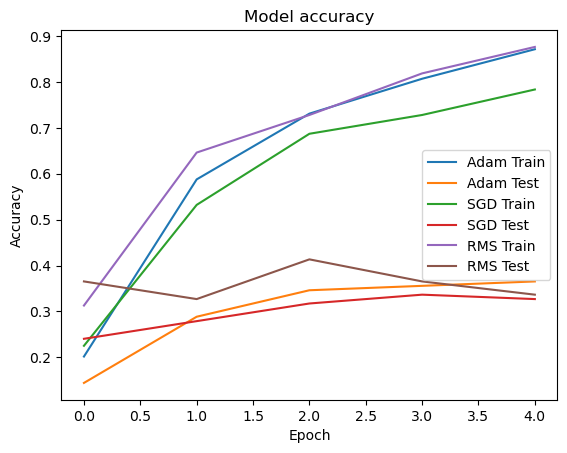

In [62]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.plot(accuracies_RMS, label = "RMS Train")
plt.plot(val_accuracies_RMS, label = "RMS Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [63]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

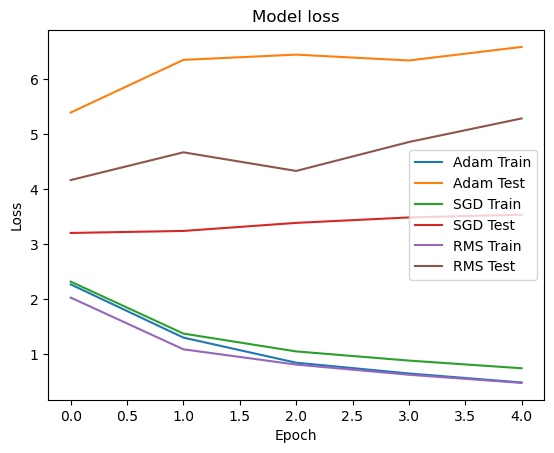

In [64]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.plot(losses_RMS, label = "RMS Train")
plt.plot(val_losses_RMS, label = "RMS Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [65]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [48]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [53]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [54]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [49]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

 16/281 [>.............................] - ETA: 16:46

In [51]:
print(len(pred_adam),"\n",pred_adam)

7025 
 [[1.2833033e-02 1.3147807e-04 1.7580627e-03 ... 4.7949774e-04
  7.0513203e-04 1.3341458e-05]
 [5.9165629e-03 2.9649807e-03 6.2566665e-05 ... 1.1178142e-04
  4.4988606e-02 6.6075370e-07]
 [1.2121375e-02 1.1366293e-03 4.1278949e-01 ... 8.3075848e-04
  4.2091280e-01 4.4829517e-07]
 ...
 [3.5595633e-02 2.0790075e-04 4.5794880e-04 ... 1.8440813e-06
  5.7064012e-02 1.4081729e-07]
 [3.0890454e-02 3.4334266e-01 8.8591754e-02 ... 5.3693121e-03
  9.9827670e-02 5.2564970e-05]
 [1.0459443e-03 7.5584002e-02 3.4575105e-02 ... 3.6531561e-05
  3.8815357e-03 5.6704321e-06]]


In [52]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [55]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

7025 
 [4 3 8 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [56]:
results_adam.head()

,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Ilya Repin,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [57]:
len(training_set_artists)

10

In [59]:
print(training_set_artists)

['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [60]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists
233 / 335 = 0.6955
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
233 / 7025 = 0.0332


## SGD

In [61]:
test_gen.reset()
pred_sgd = model_sgd.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

281/281 [==============================] - 194s 653ms/step
7025 
 [[1.3056113e-02 1.1215952e-03 1.2308335e-01 ... 2.9118247e-02
  1.9993153e-03 3.2333235e-04]
 [8.3143273e-03 5.3162877e-03 2.2876920e-04 ... 9.8496664e-04
  2.1759901e-02 6.2603813e-06]
 [5.1817051e-03 2.9974637e-04 7.8479207e-01 ... 9.9840071e-03
  3.4492221e-02 4.4815935e-04]
 ...
 [2.5756818e-01 2.6326893e-02 1.4131288e-03 ... 1.7528367e-04
  2.1248840e-01 2.0221066e-04]
 [2.3100700e-02 5.3529394e-01 7.8210041e-02 ... 4.8716762e-03
  7.6840594e-02 5.5850710e-04]
 [4.9988455e-03 1.4803004e-01 5.0036356e-02 ... 5.0127665e-03
  9.6205613e-03 2.4439651e-03]]


In [62]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [63]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 9
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,Ivan Shishkin,Jan Matejko


In [64]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [65]:
testing_new_images(results_sgd, training_set_artists)

test accuracy on new images for TRAINED artists
227 / 335 = 0.6776
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
227 / 7025 = 0.0323


## RMSprop

In [66]:
test_gen.reset()
pred_RMS = model_RMS.predict(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_RMS),"\n",pred_RMS)

281/281 [==============================] - 194s 655ms/step
7025 
 [[2.1443799e-02 2.7314452e-03 1.9525861e-03 ... 7.1664699e-06
  7.4858626e-04 1.2445415e-03]
 [1.7144992e-04 4.5708535e-04 4.1855793e-07 ... 1.9475513e-06
  8.5016536e-03 8.8260066e-07]
 [1.5640775e-03 3.2066507e-03 8.0450183e-01 ... 5.2702957e-04
  6.6229612e-02 1.8388973e-06]
 ...
 [6.5013796e-02 1.3065257e-03 2.0052115e-05 ... 5.2633203e-07
  1.7853242e-01 1.7775544e-07]
 [5.2264878e-03 6.4723516e-01 5.4563824e-02 ... 3.0369400e-03
  1.5838053e-02 4.9470534e-04]
 [5.6721634e-05 4.6246450e-02 6.1807758e-03 ... 6.9209425e-05
  7.8524435e-03 2.4185749e-05]]


In [67]:
predicted_class_indices_RMS = np.argmax(pred_RMS,axis=1)

In [68]:
results_RMS = retrieve_results(predicted_class_indices_RMS, train_gens)
results_RMS.head()

7025 
 [4 3 2 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


,Filename,Predictions,Real Values
0,836.jpg,Pablo Picasso,kiri nichol
1,49823.jpg,Marc Chagall,Hiroshige
2,32996.jpg,Pierre-Auguste Renoir,Paul Serusier
3,77203.jpg,Marc Chagall,Hiroshige
4,75956.jpg,John Singer Sargent,Jan Matejko


In [85]:
print(len(training_set_artists))
print(training_set_artists)

10
['Ivan Aivazovsky', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Marc Chagall', 'Pablo Picasso', 'Zdislav Beksinski', 'Ivan Shishkin', 'Gustave Dore', 'Ilya Repin', 'Giovanni Battista Piranesi']


In [69]:
testing_new_images(results_RMS, training_set_artists)

test accuracy on new images for TRAINED artists
231 / 335 = 0.6896
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
231 / 7025 = 0.0329


# Improving our best model

with 10400 images and 5 epochs
- Adam: test accuracy on new images for TRAINED artists 209 / 335 = 0.6239
- SGD: test accuracy on new images for TRAINED artists 178 / 335 = 0.5313
- RMSProp: test accuracy on new images for TRAINED artists 189 / 335 = 0.5642

with 13000 images and 20 epochs
- Adam: test accuracy on new images for TRAINED artists 233 / 335 = 0.6955
- SGD: test accuracy on new images for TRAINED artists 227 / 335 = 0.6776
- RMSProp: test accuracy on new images for TRAINED artists 231 / 335 = 0.6896


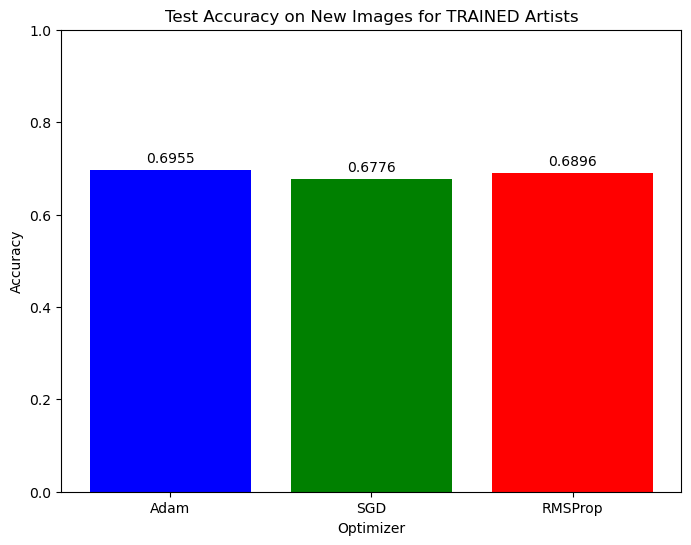

In [70]:
import matplotlib.pyplot as plt

# Dades d'accuràcia per als diferents optimitzadors
optimizers = ['Adam', 'SGD', 'RMSProp']
accuracies = [0.6955, 0.6776, 0.6896]

# Crear el gràfic de barres
plt.figure(figsize=(8, 6))
plt.bar(optimizers, accuracies, color=['blue', 'green', 'red'])

# Afegir títol i etiquetes
plt.title('Test Accuracy on New Images for TRAINED Artists')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

# Mostrar els valors d'accuràcia sobre les barres
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

# Mostrar el gràfic
plt.ylim(0, 1)  # Ajustar el límit de l'eix Y per visualitzar millor les barres
plt.show()


## Finetuning
We finetune Adam

### Freezing all the model

In [71]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam.layers[0]
layer1 = model_adam.layers[1]

In [72]:
layer0.trainable = False
layer1.trainable = False

In [73]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [74]:
# import wandb
# from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
# wandb.login()
# # 0927244f833ccea1b247099feaaaf54084a5c30c

# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_frozen_13000im_10art"
)

In [75]:
# wandb
MAX_EPOCHS = 20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 #

histories_adam_frozen = model_adam.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 2.9025 - accuracy: 0.1142 - val_loss: 2.9202 - val_accuracy: 0.0305
Epoch 8/20
8/8 [==================

In [76]:
run.finish()

batch/accuracy,▄▃▅▄▅▅▄▆▄▄▄▅▆▃▁▄▄█▁▇
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆▅█▃▂▄▅▁▂▇▄▃▃▂█▁▆▃█▃
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▁█▅▅█▅▅█▅█▅█▅▅▅▅█▅▅█
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,██▁▅▁█▅▅▅██▅█▅▁▁▅▁▁▅
batch/accuracy,0.17308


In [92]:
# manual
histories_adam_frozen = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_frozen.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 19s 2s/step - loss: 3.1271 - accuracy: 0.0497 - val_loss: 2.4236 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1126 - accuracy: 0.0585 - val_loss: 2.4460 - val_accuracy: 0.0865
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 14s 2s/step - loss: 3.1243 - accuracy: 0.0556 - val_loss: 2.5057 - val_accuracy: 0.0962
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 16s 2s/step - loss: 3.1022 - accuracy: 0.0497 - val_loss: 2.5226 - val_accuracy: 0.0769
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 3.1418 - accuracy: 0.0522 - val_loss: 2.4666 - val_accuracy: 0.0865


In [93]:
accuracies_adam_frozen = []
val_accuracies_adam_frozen = []
losses_adam_frozen = []
val_losses_adam_frozen = []
for hist in histories_adam_frozen:
    if hist:
        accuracies_adam_frozen += hist.history['accuracy']
        val_accuracies_adam_frozen += hist.history['val_accuracy']
        losses_adam_frozen += hist.history['loss']
        val_losses_adam_frozen += hist.history['val_loss']

### Unfreezing layer1

In [77]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam_unfrozen1 = Sequential()

model_adam_unfrozen1.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam_unfrozen1.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam_unfrozen1.layers[0]
layer1 = model_adam_unfrozen1.layers[1]

In [78]:
layer0.trainable = False
layer1.trainable = True

In [79]:
model_adam_unfrozen1.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [80]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_unfrozen1_13000im_10art"
)

In [81]:
# wandb
histories_adam_unfrozen1 = model_adam_unfrozen1.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)


Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 2.9138 - accuracy: 0.1447 - val_loss: 4.8698 - val_accuracy: 0.1908
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 1.5696 - accuracy: 0.4594 - val_loss: 5.6719 - val_accuracy: 0.2901
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.9483 - accuracy: 0.6980 - val_loss: 5.8893 - val_accuracy: 0.3206
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.6642 - accuracy: 0.7995 - val_loss: 6.1617 - val_accuracy: 0.3359
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.4971 - accuracy: 0.8604 - val_loss: 6.1832 - val_accuracy: 0.3359
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.3980 - accuracy: 0.9061 - val_loss: 6.1984 - val_accuracy: 0.3359
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.3204 - accuracy: 0.9391 - val_loss: 6.2609 - val_accuracy: 0.3359
Epoch 8/20
8/8 [==================

In [82]:
run.finish()

batch/accuracy,▁▃▆▆▆▇▇█████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▆▇▇██████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▆▆▆▇▆▇▇▇█▇██▇█
epoch/val_loss,▁▅▆██████████▇▇█████
batch/accuracy,1.0


In [98]:
# manual
histories_adam_unfrozen1 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen1.append(
            model_adam_unfrozen1.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 49s 2s/step - loss: 1.6539 - accuracy: 0.4883 - val_loss: 111.8660 - val_accuracy: 0.1154
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.9621 - accuracy: 0.7456 - val_loss: 1932.8289 - val_accuracy: 0.1250
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.6401 - accuracy: 0.8538 - val_loss: 2012.3904 - val_accuracy: 0.0385
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7885 - accuracy: 0.7982 - val_loss: 16352.1006 - val_accuracy: 0.1346
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.4680 - accuracy: 0.8684 - val_loss: 61595.7578 - val_accuracy: 0.1731


In [99]:
accuracies_adam_unfrozen1  = []
val_accuracies_adam_unfrozen1  = []
losses_adam_unfrozen1 = []
val_losses_adam_unfrozen1 = []
for hist in histories_adam_unfrozen1:
    if hist:
        accuracies_adam_unfrozen1 += hist.history['accuracy']
        val_accuracies_adam_unfrozen1 += hist.history['val_accuracy']
        losses_adam_unfrozen1 += hist.history['loss']
        val_losses_adam_unfrozen1 += hist.history['val_loss']

### Unfreezing layer1 and layer0

In [83]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam_unfrozen2 = Sequential()

model_adam_unfrozen2.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam_unfrozen2.add(Dense(
  num_classes,
  activation='softmax'
))

layer0 = model_adam_unfrozen2.layers[0]
layer1 = model_adam_unfrozen2.layers[1]

In [84]:
layer0.trainable = True
layer1.trainable = True

In [85]:
model_adam_unfrozen2.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [86]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam_unfrozen2_13000im_10art"
)

In [87]:
# wandb
histories_adam_unfrozen2 = model_adam_unfrozen2.fit(
    x=train_gens[0],
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)

Epoch 1/20
8/8 [==============================] - 54s 2s/step - loss: 1.8995 - accuracy: 0.4695 - val_loss: 81.8262 - val_accuracy: 0.1527
Epoch 2/20
8/8 [==============================] - 13s 2s/step - loss: 0.9317 - accuracy: 0.7360 - val_loss: 7927.9980 - val_accuracy: 0.0153
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.7303 - accuracy: 0.8071 - val_loss: 12890.9775 - val_accuracy: 0.1603
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.5546 - accuracy: 0.8477 - val_loss: 19917.9297 - val_accuracy: 0.0229
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.2987 - accuracy: 0.9239 - val_loss: 7613.6284 - val_accuracy: 0.0229
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.1434 - accuracy: 0.9594 - val_loss: 3530.8250 - val_accuracy: 0.0229
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.0635 - accuracy: 0.9848 - val_loss: 939.0467 - val_accuracy: 0.0229
Epoch 8/20
8/8

In [88]:
run.finish()

batch/accuracy,▁▆▆▇▇███████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▆▇██████▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▆▁▇▁▁▁▁▂▁▁▃▃▄▃▄▆▅▆█▆
epoch/val_loss,▁▄▆█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.98077


In [103]:
# manual
histories_adam_unfrozen2 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam_unfrozen2.append(
            model_adam_unfrozen2.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 47s 2s/step - loss: 1.6962 - accuracy: 0.4942 - val_loss: 1394.5631 - val_accuracy: 0.0577
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8346 - accuracy: 0.7339 - val_loss: 492.2099 - val_accuracy: 0.0288
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.7245 - accuracy: 0.8158 - val_loss: 609.2695 - val_accuracy: 0.1058
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.8375 - accuracy: 0.7778 - val_loss: 8467.7725 - val_accuracy: 0.0673
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 15s 2s/step - loss: 0.5357 - accuracy: 0.8567 - val_loss: 3787.8933 - val_accuracy: 0.0096


In [104]:
accuracies_adam_unfrozen2  = []
val_accuracies_adam_unfrozen2  = []
losses_adam_unfrozen2 = []
val_losses_adam_unfrozen2 = []
for hist in histories_adam_unfrozen2:
    if hist:
        accuracies_adam_unfrozen2 += hist.history['accuracy']
        val_accuracies_adam_unfrozen2 += hist.history['val_accuracy']
        losses_adam_unfrozen2 += hist.history['loss']
        val_losses_adam_unfrozen2 += hist.history['val_loss']


### Comparision finetunings

#### Accuracies

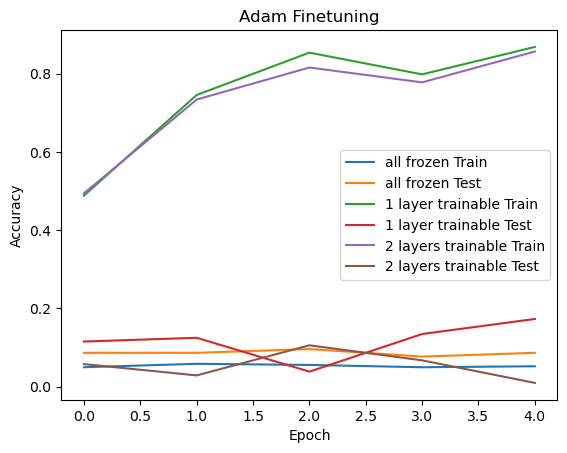

In [105]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam_frozen, label = "all frozen Train")
plt.plot(val_accuracies_adam_frozen, label = "all frozen Test")

plt.plot(accuracies_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_accuracies_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(accuracies_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_accuracies_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [106]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

#### Losses

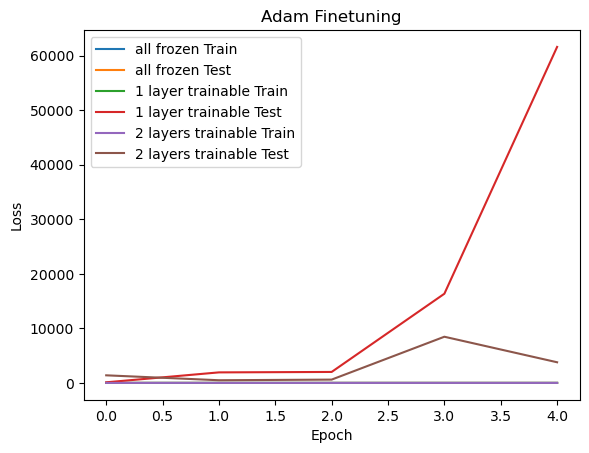

In [107]:
# Plot training & validation accuracy values
plt.plot(losses_adam_frozen, label = "all frozen Train")
plt.plot(val_losses_adam_frozen, label = "all frozen Test")

plt.plot(losses_adam_unfrozen1, label = "1 layer trainable Train")
plt.plot(val_losses_adam_unfrozen1, label = "1 layer trainable Test")

plt.plot(losses_adam_unfrozen2, label = "2 layers trainable Train")
plt.plot(val_losses_adam_unfrozen2, label = "2 layers trainable Test")

plt.title('Adam Finetuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [108]:
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_finetuning_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

## Predictions

In [89]:
model = model_adam_unfrozen1

In [90]:
test_gen.reset()
pred_adam = model.predict(test_gen)
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

281/281 [==============================] - 193s 652ms/step


In [92]:
results_adam_unfrozen1 = retrieve_results(predicted_class_indices_adam, train_gens)

7025 
 [4 3 8 ... 3 1 3]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 7025 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [93]:
testing_new_images(results_adam_unfrozen1, training_set_artists)

test accuracy on new images for TRAINED artists
229 / 335 = 0.6836
test accuracy on new images for UNEXPECTED artists
unexpected_match 0
unexpected_count 6690
0 / 6690 = 0.0000
test accuracy on new images
229 / 7025 = 0.0326


# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [95]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [97]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


### Real values

In [104]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [105]:

grouped_data

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x